<a href="https://colab.research.google.com/github/oserikov/nn_harmony_np/blob/master/nn_phonology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/oserikov/nn_harmony_np.git
%cd nn_harmony_np

Cloning into 'nn_harmony_np'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 140 (delta 6), reused 1 (delta 0), pack-reused 125
Receiving objects: 100% (140/140), 13.18 MiB | 14.76 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/nn_harmony_np


In [3]:
from nn_model import NNModel, ModelStateLogDTO
from nn_model import NNModel, ModelStateLogDTO
from experiment_datasets_creator import ExperimentCreator
from phonology_tool import PhonologyTool
from experiment_datasets_creator import ExperimentCreator
from phonology_tool import PhonologyTool
from google.colab import files
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image, display
from sklearn.tree import export_graphviz
import pydotplus
import pickle

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
train_data_fn = "data/tur_apertium_words.txt"


train_dataset = []
alphabet = set()
with open(train_data_fn, 'r', encoding="utf-8") as train_data_f:
    for line in train_data_f:
        train_dataset.append(line.strip())
        [alphabet.add(c) for c in line.strip()]



In [0]:
training_mode = "pretrained"

assert training_mode in ["train", "pretrained"]

if training_mode == "train":
    EPOCHS_NUM = 300


    hidden_sizes = [2,3,4,5,6,7,8,9,10]
    hidden_types = ["sigmoid", "tanh", "relu"]

    model_filenames = []

    for hidden_type in hidden_types:
        for hidden_size in hidden_sizes:
            model_filename = f"model_size_{hidden_size}_activation_{hidden_type}.pkl"

            model = NNModel(alphabet, hidden_size, activation=hidden_type)

            train_data = [(entry[:-1], entry[1:]) for entry in train_dataset]
            for epoch_num, epoch_loss in model.train(train_data, EPOCHS_NUM):
                print('\t'.join([f"hidden_size: {hidden_size}", 
                                 f"hidden_type:{hidden_type}",
                                 f"epoch_num: {epoch_num}", 
                                 f"epoch_loss: {epoch_loss}"]))

            model.save(model_filename)
            model_filenames.append(model_filename)

            
if training_mode == "pretrained":
    !cp models/*.pkl ./
    model_filenames = !ls *.pkl
    model_filenames = [fn for fns in model_filenames for fn in fns.split()]


In [0]:
if training_mode == "train":
    [files.download(model_filename) for model_filename in model_filenames]

In [7]:

test_data_fn = "data/tur_swadesh.txt"
phonology_features_filename = "data/tur_phon_features.tsv"

datasets = []
for model_filename in model_filenames:
    model_filename_prefix = model_filename.rstrip(".pkl")

    model = NNModel.load_model(model_filename)

    test_dataset = []
    with open(test_data_fn, 'r', encoding="utf-8") as test_data_f:
        for line in test_data_f:
            if all(c in model.alphabet for c in line.strip()):
                test_dataset.append(line.strip())

    phonologyTool = PhonologyTool(phonology_features_filename)
    experimentCreator = ExperimentCreator(model, test_dataset, phonologyTool)

    # front_harmony_dataset
    front_harmony_dataset_fn = model_filename_prefix+ "_front_harmony_dataset.tsv"
    front_harmony_dataset = experimentCreator.make_dataset_pretty(experimentCreator.front_harmony_dataset())
    experimentCreator.save_dataset_to_tsv(front_harmony_dataset, front_harmony_dataset_fn)
    datasets.append(front_harmony_dataset_fn)
    
    # vov_vs_cons_dataset
    vov_vs_cons_dataset_fn = model_filename_prefix+ "_vov_vs_cons_dataset.tsv"
    vov_vs_cons_dataset = experimentCreator.make_dataset_pretty(experimentCreator.vov_vs_cons_dataset())
    experimentCreator.save_dataset_to_tsv(vov_vs_cons_dataset, vov_vs_cons_dataset_fn)
    datasets.append(vov_vs_cons_dataset_fn)
    
    # front_feature_dataset
    front_feature_dataset_fn = model_filename_prefix+ "_front_feature_dataset.tsv"
    front_feature_dataset = experimentCreator.make_dataset_pretty(experimentCreator.front_feature_dataset())
    experimentCreator.save_dataset_to_tsv(front_feature_dataset, front_feature_dataset_fn)
    datasets.append(front_feature_dataset_fn)
    
    # is_starting_consonant_cluster_dataset
    is_starting_consonant_cluster_dataset_fn = model_filename_prefix+ "_is_starting_consonant_cluster_dataset.tsv"
    is_starting_consonant_cluster_dataset = experimentCreator.make_dataset_pretty(experimentCreator.is_starting_consonant_cluster_dataset())
    experimentCreator.save_dataset_to_tsv(is_starting_consonant_cluster_dataset, is_starting_consonant_cluster_dataset_fn)
    datasets.append(is_starting_consonant_cluster_dataset_fn)
    
    # second_consonant_in_cluster_dataset
    second_consonant_in_cluster_dataset_fn = model_filename_prefix+ "_second_consonant_in_cluster_dataset.tsv"
    second_consonant_in_cluster_dataset = experimentCreator.make_dataset_pretty(experimentCreator.second_consonant_in_cluster_dataset())
    experimentCreator.save_dataset_to_tsv(second_consonant_in_cluster_dataset, second_consonant_in_cluster_dataset_fn)
    datasets.append(second_consonant_in_cluster_dataset_fn)
    
    # voiced_stop_consonant_dataset
    voiced_stop_consonant_dataset_fn = model_filename_prefix+ "_voiced_stop_consonant_dataset.tsv"
    voiced_stop_consonant_dataset = experimentCreator.make_dataset_pretty(experimentCreator.voiced_stop_consonant_dataset())
    experimentCreator.save_dataset_to_tsv(voiced_stop_consonant_dataset, voiced_stop_consonant_dataset_fn)
    datasets.append(voiced_stop_consonant_dataset_fn)
    

KeyboardInterrupt: ignored

In [0]:
def tree_to_pseudo(tree, features_names):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [features_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    nodes = []

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            # print (indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            nodes.append({"id":len(nodes),
                          "feature": features[node], 
                          "threshold": threshold[node]})
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                # print (indent,"} else {")
            if right[node] != -1:
                recurse (left, right, threshold, features, right[node], depth+1)
                # print (indent,"}")
        else:
            pass
            # print (indent,"return " + str(value[node]))
    
    recurse(left, right, threshold, features, 0)
    return nodes

# tree_to_pseudo(d_tree, feature_colnames)

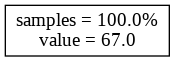

model_size_10_activation_relu_front_harmony_dataset.tsv
accuracy:  1.0




ValueError: ignored

In [19]:
for task_fn in datasets:
    
    task_df = pd.read_csv(task_fn, delimiter='\t', encoding="utf-8")

    feature_colnames = [colname 
                        for colname in task_df.columns[2:-1] 
                        if "hidden_outs" in colname]
#                         or "output_ins" in colname]
    target_colname = task_df.columns[-1]
    task_df_g = task_df.groupby(target_colname)
    task_df = task_df_g.apply(lambda x: x.sample(task_df_g.size().min())).reset_index(drop=True)
    
    for column in task_df.columns:
        if pd.api.types.is_numeric_dtype(task_df[column])\
        and not pd.api.types.is_bool_dtype(task_df[column]):
            task_df[column+"_mean"] = task_df[column].mean()

    task_df.to_csv(task_fn.replace('.tsv', '_balanced.tsv'), 
                   sep='\t', encoding="utf-8")
    y = task_df[target_colname]
    X = task_df[feature_colnames]

    dt = DecisionTreeClassifier(max_depth=2)
    dt.fit(X, y)
    accuracy = dt.score(X, y)
    prediction = dt.predict(X)
    dt_nodes = tree_to_pseudo(dt, feature_colnames)
    for dt_node in dt_nodes:
        dt_node_id = dt_node["id"]
        dt_node_feature = dt_node["feature"]
        dt_node_treshold = dt_node["threshold"]
        dt_node_feature_colname = f"node_{dt_node_id}_feature"
        dt_node_treshold_colname = f"node_{dt_node_id}_threshold"
        dt_node_condition_colname = f"node_{dt_node_id}_condition"
        
        task_df[dt_node_feature_colname] = dt_node_feature
        task_df[dt_node_treshold_colname] = dt_node_treshold
        dt_node_condition = task_df[dt_node_feature] <= dt_node_treshold
        task_df[dt_node_condition_colname] = dt_node_condition

    accuracy_colname = "accuracy"
    task_df[accuracy_colname] = accuracy

    prediction_colname = "prediction"
    task_df[prediction_colname] = prediction
    
    task_df.to_csv(task_fn, sep='\t')



    model_size = int([e for e in task_fn.split('_') if e.isnumeric()][0])
   
    # or "voiced_stop" in task_fn or "vov_vs_cons" in task_fn \
  
    # if (accuracy < 0.8 or model_size > 8) \
    # or "front_feature" in task_fn or "front_harmony" in task_fn:# or accuracy < 0.9:
    #     continue

    tree_dot_fn = task_fn.replace(".tsv", ".dot")
    tree_pkl_fn = task_fn.replace(".tsv", ".pkl")
    with open(tree_pkl_fn, 'wb') as f: pickle.dump(dt, f)
    # dot_data = StringIO()
    export_graphviz(dt, out_file=tree_dot_fn, special_characters=True, feature_names=X.columns, 
                    class_names=True, proportion=True, impurity=False)
    with open(tree_dot_fn, 'r', encoding="utf-8") as tree_f:
        dot_data = tree_f.read()
    graph = pydotplus.graph_from_dot_data(dot_data)#dot_data.getvalue())  
    display(Image(graph.create_png()))
    print(task_fn)
    print("accuracy: ", accuracy)

    print("======================")
    print("")
    print("")

    

In [0]:
!mkdir analysis_data && cp *.tsv *.dot *.pkl analysis_data && zip -r analysis_data.zip analysis_data


In [0]:
!mv analysis_data.zip /content/drive/My\ Drive/